**THis is an updated version of how the KL Divergence is computed and how the trees are trained. It makes use of parallel processing and the syntax has been simplified.**

In [19]:
import sys
import numpy as np 
import pandas as pd
import warnings
import sympy 
import matplotlib as plt
warnings.filterwarnings('ignore')

from copy import deepcopy
from ipywidgets import IntProgress
from IPython.display import display

sys.path.append('./')
sys.path.append('./Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par

#File related libraries
from expression_writter import *

#Writing files libraries
import re
from file_creator import *
import os
import pickle
import time

#librarires for parallel processing
import time
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
import itertools

Adding the file of a function to be studied. Several functions will be repeated and we will only count them onece, so we first have to filter that.

In [20]:
df = pd.read_csv("./New_Experiment/Training_Datasets/Prob_Comparison_sin(x**2)*cos(x) - 0.75.csv")
desc_lengths, expressions, neg_log_probs = df['bms_E'], df['expression'], df['minus_log_prob_tree']
expressions = expressions.str.strip()
expressions.head()


0              (log(cosh(_a5_)) + sinh(_a2_))
1    (_a1_ * exp(cos(exp(sinh(cosh(_a2_))))))
2        (fac(_a0_) * sqrt(pow2(sinh(_a3_))))
3                         (_a0_ / pow3(_a9_))
4      (_a7_ / exp(sin((sinh(_a4_) / _a3_))))
Name: expression, dtype: object

Variables and parameters config

In [22]:
XLABS = ['x'] #Change to just x if one variable models
parameters = ['_a%d_' % i for i in range(10)]

#creating empty tree and probtree
model = Tree(
    variables = XLABS,
    parameters = parameters,
)

#Probability tree
Tree_prob =ProbTree(
    tree = model,
    variables = XLABS,
    parameters = parameters,
) 

#name of the file where the prob_tree will be stored
objFile = "./New_Experiment/Prob_Trees/Prob_Tree_sin(x**2)*cos(x) - 0.75"

### Parallelized version of the KL Divergence computation

In [23]:
from concurrent.futures import ThreadPoolExecutor 
## Función process_batch a nivel de módulo (requerido para paralelización)
def process_batch(args):
    """
    Processes a data batch and computes its contribution to the KL Divergence
    Args: (desc_batch, expr_batch, probTree)
    """
    desc_batch, expr_batch, probTree = args
    batch_results = []
    
    for desc_length, expression in zip(desc_batch, expr_batch):
        # Build the tree atribute in prob tree for each expression
        probTree.tree.build_from_string(expression)
        exp_prob_tree = probTree.pr_tree()
        #print(exp_prob_tree)
        contribution = -np.exp(-desc_length) * (desc_length + np.log(exp_prob_tree))
        if np.isinf(contribution):
            print("The contribution is infinite")
            print(f"desc length: {desc_length}")
            print(f"prob expression = {exp_prob_tree}")
            print(f"expression : {expression}")
        batch_results.append(contribution)
    return np.sum(batch_results) if batch_results else 0

def KLDivergence_optimized(
    desc_length_df,
    expression_df,
    probTree,
    n_workers=None,
    batch_size=1000
):
    """
    Versión optimizada para DataFrames con paralelización
    """

    # Validación de inputs
    assert len(desc_length_df) == len(expression_df), "DataFrames deben tener el mismo tamaño"
    
    # Convertimos a listas para procesamiento eficiente
    desc_lengths_list = desc_length_df.tolist()
    expressions_list = expression_df.tolist()
    
    # Configuración de paralelización
    n_workers = n_workers or max(1, mp.cpu_count() - 1)
    
    # Creación de lotes con todos los parámetros necesarios
    batch_args = [
        (
            desc_lengths_list[i:i+batch_size], 
            expressions_list[i:i+batch_size],
            probTree
        )
        for i in range(0, len(desc_lengths_list), batch_size)
    ]
    
    # Procesamiento paralelo
    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        results = list(executor.map(process_batch, batch_args))
   
    return sum(results)


KL = KLDivergence_optimized(
    desc_length_df = desc_lengths,
    expression_df = expressions,
    probTree = Tree_prob,
    n_workers=None,
    batch_size=1000
)
print(KL)    


6.36568787116708


Now, a copy of the current Probability Tree will be walked through and the probabilites of a node chosen at random will be changed (the other probabilites will be accordingly adapted). Then, the KL Divergence will be computed again, and if its value is smaller then the change will be accepted, otherwise rejected.

In [24]:
##### Kullback-Leibler Divergence random improvement
def KL_improve(Tree_prob, D):
    Tree_copy = Tree_prob.tree_copy()
    Tree_copy.modify_random_prob()
    newD = KLDivergence_optimized(
        desc_length_df = desc_lengths,
        expression_df = expressions,
        probTree=Tree_copy
    )
    #newD = KLDivergence(filepath= newPath, probTree=Tree_copy)
    if newD < D:
        D = newD
        Tree_prob = Tree_copy #replace with the better prob tree        
    return D, Tree_prob, newD #record all values that are achieved with this procedure, and update the tree in case of improvement       
D = KLDivergence_optimized(desc_length_df = desc_lengths, expression_df=expressions, probTree = Tree_prob)
print("Initial KL Divergence: " + str(D))

Initial KL Divergence: 6.36568787116708


Files with the evolution of the KL Divergence will be saved and stored in the folder named `KL`.

In [25]:
N = 25000
initialD = D
KL_evolution_filepath = "./New_Experiment/KL Evolution/KL_Evolution_sin(x**2)*cos(x) - 0.75.txt"
with open(KL_evolution_filepath, 'w') as f:
    f.write(f"{D}\n")
    bar = IntProgress(min = 0, max = N, description='Running:')
    display(bar)
    for i in range(0,N):
        D, Tree_prob, newD =  KL_improve(Tree_prob = Tree_prob, D = D)
        f.write(f"{newD}\n")
        bar.value += 1
        if i % 1000 == 0:
            f.flush()
            #Now we add the last probability tree we have
            with open(objFile, 'wb') as file:
                pickle.dump(Tree_prob, file)

print('Finished')

IntProgress(value=0, description='Running:', max=25000)

Finished


In [26]:
Tree_prob.tree

_a7_

In [27]:
#Now we add the last probability tree we have
with open(objFile, 'wb') as f:
    pickle.dump(Tree_prob, f)

Plot the evolution of the KL divergence

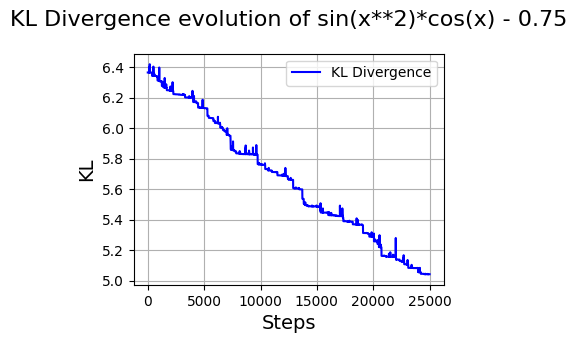

In [28]:
steps = np.arange(0,N+1,1)
KL = []

with open(KL_evolution_filepath, 'r') as f:
    for line in f:
        KL.append(float(line.strip()))

steps = np.arange(0,len(KL),1)

title = "KL Divergence evolution of sin(x**2)*cos(x) - 0.75"
output_folder = "./New_Experiment/Figures/"
output_filename = f"KL_Evolution_sin(x**2)*cos(x) - 0.75.png"
output_path = os.path.join(output_folder, output_filename)

plt.figure(figsize = (4,3))
plt.plot(steps, KL, label="KL Divergence", color="blue")
plt.xlabel("Steps", fontsize=14)
plt.ylabel("KL", fontsize=14)
plt.title(title, fontsize=16, pad=20)
plt.legend(loc="best", fontsize=10)
plt.grid(True)
plt.savefig(output_path, dpi = 150, bbox_inches = 'tight')


plt.show()


In [29]:
Tree_prob.root.prob_list

{'_a0_': 0.07474174161300992,
 '_a1_': 0.07421653177785638,
 '_a2_': 0.07709262820175074,
 '_a3_': 0.07874924652164901,
 '_a4_': 0.06930325829206457,
 '_a5_': 0.07219213805694782,
 '_a6_': 0.07552779782769181,
 '_a7_': 0.0725433141128228,
 '_a8_': 0.07344230023842802,
 '_a9_': 0.074336824140566,
 'x': 0.03085781079574533,
 'sin': 0.021580166156466185,
 'cos': 0.004601917398775447,
 'tan': 1.075822650931663e-06,
 'exp': 0.005154450436537222,
 'log': 1.0007795644430402e-06,
 'sinh': 0.023159517500543268,
 'cosh': 1.0319817235272296e-06,
 'tanh': 0.030756312552874757,
 'pow2': 0.0028907654090781667,
 'pow3': 0.001619446881814801,
 'abs': 0.025401099736180655,
 'sqrt': 0.013266115869589054,
 'fac': 0.006211376822685776,
 '-': 0.03172906585116794,
 '+': 0.021329912969023382,
 '*': 0.015930471968056654,
 '/': 0.023027714481609035,
 '**': 0.00033496580312645163}